<div align='center'><font size="5" color='#353B47'>Predicting Stock Prices</font></div>
<div align='center'><font size="4" color="#353B47">How to use LSTMs</font></div>
<br>
<hr>

**<font color="#5963ab" size="4">Context</font>**

> This notebook is designed to demonstrate a concise script for predicting stock prices utilizing a Long Short-Term Memory (LSTM) model. I have provided an introduction to <a href="https://www.kaggle.com/bryanb/introduction-to-time-series-analysis/edit/run/53321733">Time Series Analysis</a>, which I encourage you to review if you have not already done so.

<div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Imports</h1></div>

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LeakyReLU, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Preprocessing</h1></div>

In [2]:
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()



df = pdr.get_data_yahoo("^NSEI", start="2020-11-1", end="2023-09-01")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-02,11697.349609,11725.650391,11557.400391,11669.150391,11669.150391,568400
2020-11-03,11734.450195,11836.200195,11723.299805,11813.500000,11813.500000,674300
2020-11-04,11783.349609,11929.650391,11756.400391,11908.500000,11908.500000,667300
2020-11-05,12062.400391,12131.099609,12027.599609,12120.299805,12120.299805,632500
2020-11-06,12156.650391,12280.400391,12131.849609,12263.549805,12263.549805,576800


In [3]:
df['sentiment'] = np.random.uniform(-1, 1, size=len(df))



In [ ]:
df.head(4)

,Open,High,Low,Close,Adj Close,Volume,sentiment
Date,,,,,,,
2020-11-02,11697.349609,11725.650391,11557.400391,11669.150391,11669.150391,568400,-0.541900
2020-11-03,11734.450195,11836.200195,11723.299805,11813.500000,11813.500000,674300,-0.093973
2020-11-04,11783.349609,11929.650391,11756.400391,11908.500000,11908.500000,667300,-0.425938
2020-11-05,12062.400391,12131.099609,12027.599609,12120.299805,12120.299805,632500,0.867450


In [4]:
df = df.filter(['Date','Close', 'sentiment'])
df.columns = ['price', 'sentiment']
df.head(10)

,price,sentiment
Date,,
2020-11-02,11669.150391,-0.423329
2020-11-03,11813.500000,0.713072
2020-11-04,11908.500000,-0.736987
2020-11-05,12120.299805,-0.770527
2020-11-06,12263.549805,0.205720
2020-11-09,12461.049805,0.063525
2020-11-10,12631.099609,-0.211909
2020-11-11,12749.150391,0.648751
2020-11-12,12690.799805,0.609584


In [ ]:
l = int(0.8 * len(df))
print(l)

561


In [ ]:
d1, d2 = df[:l] , df[l:]

In [ ]:
d1.tail(5)

,Open,High,Low,Close,Adj Close,Volume,sentiment
Date,,,,,,,
2023-01-30,17541.949219,17709.150391,17405.550781,17648.949219,17648.949219,432400,0.620162
2023-01-31,17731.449219,17735.699219,17537.550781,17662.150391,17662.150391,398300,0.949978
2023-02-01,17811.599609,17972.199219,17353.400391,17616.300781,17616.300781,512900,0.345483
2023-02-02,17517.099609,17653.900391,17445.949219,17610.400391,17610.400391,490100,-0.303283
2023-02-03,17721.750000,17870.300781,17584.199219,17854.050781,17854.050781,424100,-0.404273


In [ ]:
d2.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-06,17818.550781,17823.699219,17698.349609,17764.599609,17764.599609,282500
2023-02-07,17790.099609,17811.150391,17652.550781,17721.500000,17721.500000,354400
2023-02-08,17750.300781,17898.699219,17744.150391,17871.699219,17871.699219,291000


In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.filter(['price', 'sentiment']))

In [6]:
features = scaled_data
target = scaled_data[:,0]

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = False)

In [9]:
win_l = 10
num_f = 2
train_gen = TimeseriesGenerator(x_train, y_train, length = win_l, sampling_rate = 1, batch_size=32)
test_gen = TimeseriesGenerator(x_test, y_test, length = win_l, sampling_rate = 1, batch_size=32)

In [ ]:
train_gen[0]

(array([[[0.        , 0.22911   ],
         [0.01737059, 0.45359796],
         [0.0288026 , 0.2872264 ],
         [0.05428994, 0.93543591],
         [0.07152821, 0.94279588],
         [0.09529476, 0.45859995],
         [0.11575803, 0.05646458],
         [0.1299639 , 0.44417687],
         [0.12294217, 0.4751507 ],
         [0.12645004, 0.96420992]],
 
        [[0.01737059, 0.45359796],
         [0.0288026 , 0.2872264 ],
         [0.05428994, 0.93543591],
         [0.07152821, 0.94279588],
         [0.09529476, 0.45859995],
         [0.11575803, 0.05646458],
         [0.1299639 , 0.44417687],
         [0.12294217, 0.4751507 ],
         [0.12645004, 0.96420992],
         [0.14501201, 0.54826031]],
 
        [[0.0288026 , 0.2872264 ],
         [0.05428994, 0.93543591],
         [0.07152821, 0.94279588],
         [0.09529476, 0.45859995],
         [0.11575803, 0.05646458],
         [0.1299639 , 0.44417687],
         [0.12294217, 0.4751507 ],
         [0.12645004, 0.96420992],
         [0.14

<div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">LSTM Model</h1></div>

**<font color="#5963ab" size="4">What is a LSTM ?</font>**

> Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.
>
> LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
>
> All recurrent neural networks have the form of a chain of repeating modules of neural network.

You can find more details here: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [10]:
import tensorflow as tf

In [11]:
# def LSTM_model():
#     """
#     Create and configure an LSTM model for stock price prediction.

#     :return: The configured LSTM model (keras.Sequential)
#     """

#     # Initialize a sequential model
#     model = Sequential()

#     # Add the first LSTM layer with 50 units, input shape, and return sequences
#     model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(win_l, num_f))))
#     # Add dropout to prevent overfitting
#     model.add(Dropout(0.2))

#     # Add a second LSTM layer with 50 units and return sequences
#     model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
#     # Add dropout to prevent overfitting
#     model.add(Dropout(0.2))

#     # Add a third LSTM layer with 50 units
#     model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
#     # Add dropout to prevent overfitting
#     model.add(Dropout(0.2))

#     # Add a dense output layer with one unit
#     model.add(Dense(units=1))

#     return model

In [65]:
def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(win_l, num_f), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(50, return_sequences=True))(input)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Bidirectional(LSTM(50, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Bidirectional(LSTM(50, return_sequences=False))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1, name="last_dense")(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    return model

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

<div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Training</h1></div>

In [66]:
model = build_LSTM_model()


In [ ]:
# model = LSTM_model()

In [67]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 2)]           0         
                                                                 
 bidirectional_18 (Bidirect  (None, 10, 100)           21200     
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 10, 100)           0         
                                                                 
 bidirectional_19 (Bidirect  (None, 10, 100)           60400     
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 10, 100)           0         
                                                                 
 bidirectional_20 (Bidirect  (None, 100)               6040

In [ ]:
import tensorflow as tf

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="min"
)


In [69]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [70]:
# Define callbacks

model.fit_generator(
    train_gen,
    validation_data = test_gen,
    shuffle = False,
    epochs=15,
    callbacks = [early_stop]
)

Epoch 1/15


<ipython-input-70-f7ec9d907a67>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


18/18 [==============================] - 18s 264ms/step - loss: 0.0197 - val_loss: 0.0066
Epoch 2/15
18/18 [==============================] - 2s 87ms/step - loss: 0.0378 - val_loss: 0.0038
Epoch 3/15
18/18 [==============================] - 1s 36ms/step - loss: 0.0199 - val_loss: 0.0027
Epoch 4/15
18/18 [==============================] - 1s 36ms/step - loss: 0.0105 - val_loss: 0.0014
Epoch 5/15
18/18 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 6/15
18/18 [==============================] - 1s 35ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 7/15
18/18 [==============================] - 1s 67ms/step - loss: 0.0048 - val_loss: 0.0021


**<font size="2"><a href="#summary">Back to summary</a></font>**

----

In [71]:
model.evaluate_generator(test_gen, verbose="0")

<ipython-input-71-01b4199dd4d3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen, verbose="0")


0.002065035980194807

In [72]:
pred = model.predict_generator(test_gen)

<ipython-input-72-ee7734aca27d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_gen)


In [73]:
df_pred = pd.concat([pd.DataFrame(pred), pd.DataFrame(x_test[:,1:][win_l:])], axis=1)

In [74]:
rev_trans = scaler.inverse_transform(df_pred)

In [75]:
df_act = df[-1 * len(pred): ]

In [76]:
df_act['pred'] = rev_trans[:,0]

<ipython-input-76-411f530d68cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act['pred'] = rev_trans[:,0]


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [78]:
print('MSE: '+str(mean_squared_error(df_act['price'], df_act['pred'])))
print('MAE: '+str(mean_absolute_error(df_act['price'], df_act['pred'])))
print('RMSE: '+str(math.sqrt(mean_squared_error(df_act['price'], df_act['pred']))))

MSE: 142603.33872174556
MAE: 332.9070009120537
RMSE: 377.6285724382433


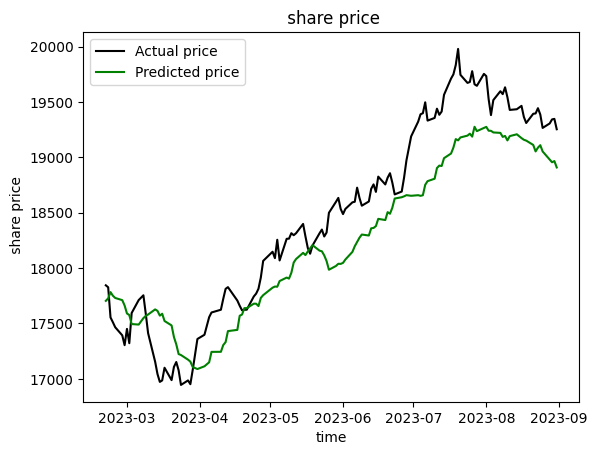

In [79]:
# Plot the actual prices using a black line
plt.plot(df_act['price'], color='black', label=f"Actual price")

# Plot the predicted prices using a green line
plt.plot(df_act['pred'], color='green', label=f"Predicted price")

# Set the title of the plot using the company name
plt.title(f" share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f" share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

<h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">References</h1>

* <a href = 'https://www.kaggle.com/bryanb/introduction-to-time-series-analysis/edit/run/53321733'>My notebook on Time series analysis</a>
* <a href = 'http://colah.github.io/posts/2015-08-Understanding-LSTMs/'>LSTM Explanations</a>
* <a href = 'https://www.kaggle.com/datasets/bryanb/cac40-stocks-dataset'>CAC 40 dataset</a>